# CNN first model

Here I use a network doing a CNN over the input. The model architecture is a CNN of the local features. These then get pooled down to the number of channels, which is then fed into a dense layer.

### Load Libraries

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch import nn, optim, cuda
from torch.utils.data.dataloader import DataLoader
from utils import Runner, EarlyStopping, TcrDataset, setup_seed
from cnn_network import SimpleCNN
import pandas as pd

Set general plotting parameters for matplotlib using seaborn

In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette="pastel")

### General parameters

In [3]:
# General parameters
data_dir = "../../data/"
data_files = [data_dir+f"datasets/P{i}_input_cdrs.npz" for i in range(1,6)]
label_files = [data_dir+f"datasets/P{i}_labels.npz" for i in range(1,6)]
model_name = "cnn_model.pt"
model_path = "stored_models/"

batch_size = 64
seed= 123

setup_seed(seed)
device = torch.device("cuda" if cuda.is_available() else "cpu")
#device= torch.device("cpu")

## Define indexing

In [4]:

########### Select Indexes TCR DATA ############

# Full model
#idx = np.arange(420)

# peptide + TCR
#idx = np.arange(179,420)

# MHC + TCR
#idx = np.concatenate([np.arange(179),np.arange(192,420)])

# TCR
#idx = np.arange(192,420)

# MHC + peptide
#idx = np.arange(192)


########### Select Indexes CDR Data ############

# Full model
# idx = np.arange(248)

# Peptide + All CDRS
idx = np.arange(179,248)

# peptide + cd

########### Select Features ###########

# All features
#local_features = np.arange(27)
#global_features = np.arange(27, 54)
#use_global_features = True

# Sequence
local_features = np.arange(20)
global_features = None
use_global_features = False

# Energy terms
#local_features = np.arange(20, 27)
#global_features = np.arange(27, 54)
#use_global_features = True

# Sequence and global energy
#local_features = np.arange(20)
#global_features = np.arange(27, 54)
#use_global_features = True


## Load Data
Partitions can be changed by altering the `data_files` and `label_files` indexing

In [5]:
train_data = TcrDataset(data_files[0], label_files[0])
train_data.add_partition(data_files[1], label_files[1])
train_data.add_partition(data_files[2], label_files[2])
val_data = TcrDataset(data_files[3], label_files[3])
test_data = TcrDataset(data_files[4], label_files[4])


# Shuffle data randomly is needed
train_data.shuffle_data()
val_data.shuffle_data()
test_data.shuffle_data()

# slicing sequence dimension
train_data.slice_data(idx)
val_data.slice_data(idx)
test_data.slice_data(idx)

input_len = train_data.data.shape[2]


In [6]:
train_dl = DataLoader(train_data, batch_size)
val_dl = DataLoader(val_data, batch_size)
test_dl = DataLoader(test_data, batch_size)

In [7]:
len(train_data), len(val_data), len(test_data)

(4174, 1532, 1207)

In [8]:
train_data.data.shape

(4174, 54, 69)

In [9]:
#Hyperparameters
epochs = 100
patience = 15
lr = 0.005
loss_weight = sum(train_data.labels) / len(train_data.labels)
weight_decay = 0.0005

# Layer parameters
cnn_channels = 30
dropout = 0.3
cnn_kernel = 3

# Loss and optimizer
criterion = nn.BCELoss(reduction='none')
stopper = EarlyStopping(patience, model_name, model_path)


In [10]:
net = SimpleCNN(local_features, global_features, use_global_features, cnn_channels=cnn_channels, dropout=dropout, cnn_kernel_size=cnn_kernel)
net.to(device)
print(net)
print("Using Device:", device)
optimizer = optim.Adam(net.parameters(), lr=lr,
    weight_decay=weight_decay,
    amsgrad=True
)

SimpleCNN(
  (cdr1a_conv): Conv1d(20, 30, kernel_size=(3,), stride=(1,), padding=(1,))
  (cdr2a_conv): Conv1d(20, 30, kernel_size=(3,), stride=(1,), padding=(1,))
  (cdr3a_conv): Conv1d(20, 30, kernel_size=(3,), stride=(1,), padding=(1,))
  (cdr1b_conv): Conv1d(20, 30, kernel_size=(3,), stride=(1,), padding=(1,))
  (cdr2b_conv): Conv1d(20, 30, kernel_size=(3,), stride=(1,), padding=(1,))
  (cdr3b_conv): Conv1d(20, 30, kernel_size=(3,), stride=(1,), padding=(1,))
  (pep_conv): Conv1d(20, 30, kernel_size=(3,), stride=(1,), padding=(1,))
  (max_pool): AdaptiveMaxPool1d(output_size=1)
  (dense1): Linear(in_features=210, out_features=64, bias=True)
  (dense_out): Linear(in_features=64, out_features=1, bias=True)
  (bn_dense): BatchNorm1d(210, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Using Device: cpu


In [11]:
# Define runners
train_runner = Runner(train_dl, net, criterion, loss_weight, device, optimizer)
val_runner = Runner(val_dl, net, criterion, loss_weight, device)
test_runner = Runner(test_dl, net, criterion, loss_weight, device)

## Training Loop

In [12]:
train_loss, val_loss, train_auc, val_auc = [], [], [], []

for epoch in range(1, epochs+1):
    train_runner.run_epoch()
    val_runner.run_epoch()
    
    train_runner.follow_performance(epoch)
    val_runner.follow_performance(epoch)
    stopper.evaluate_epoch(val_runner.loss, net, epoch)
    
    train_loss.append(train_runner.loss)
    val_loss.append(val_runner.loss)
    train_auc.append(train_runner.auc)
    val_auc.append(val_runner.auc)
    
    train_runner.reset()
    val_runner.reset()

    if stopper.stop:
        break


Epoch: 1
Train loss: 0.2067351485743667 Train MCC: 0.4225821448916716 Train AUC: 0.7895465788112556
Validation loss: 0.16732507944107056 Validation MCC: 0.6270830720487744 Validation AUC: 0.8347058516089594
Validation loss decreased. Counter reset
Epoch: 2
Train loss: 0.13436368017485648 Train MCC: 0.6797958908473773 Train AUC: 0.9176717090377822
Validation loss: 0.15777989228566489 Validation MCC: 0.6475993376645184 Validation AUC: 0.865258017529149
Validation loss decreased. Counter reset
Epoch: 3
Train loss: 0.1118445685415557 Train MCC: 0.7284544565990793 Train AUC: 0.9466674878598236
Validation loss: 0.15389450391133627 Validation MCC: 0.6624498010727016 Validation AUC: 0.8837642904375925
Validation loss decreased. Counter reset
Epoch: 4
Train loss: 0.09573626518249512 Train MCC: 0.7713616723847557 Train AUC: 0.963777108566638
Validation loss: 0.15993772943814596 Validation MCC: 0.6748719222871216 Validation AUC: 0.8866093117638905
Early Stopping Counter: 1 out of 15
Epoch: 5
Trai

(Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'))

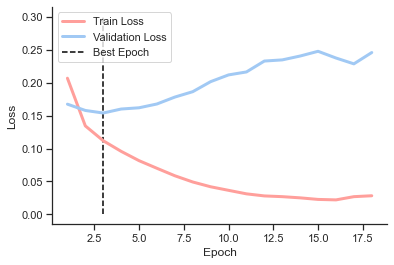

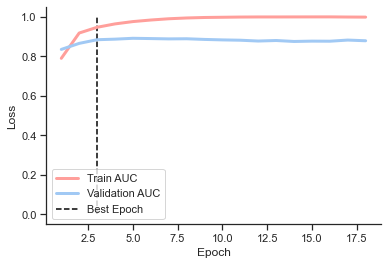

In [13]:
# Plots of training epochs
epoch = np.arange(1, len(train_loss) + 1)
plt.figure()
plt.plot(epoch, train_loss, "r", epoch, val_loss, "b", linewidth=3)
plt.vlines(stopper.best_epoch, ymin=0, ymax=0.3, colors="black", linestyles='dashed')
plt.legend(["Train Loss", "Validation Loss", "Best Epoch"])
plt.xlabel("Epoch"), plt.ylabel("Loss")

epoch = np.arange(1, len(train_loss) + 1)
plt.figure()
plt.plot(epoch, train_auc, "r", epoch, val_auc, "b", linewidth=3)
plt.vlines(stopper.best_epoch, ymin=0, ymax=1, colors="black", linestyles='dashed')
plt.legend(["Train AUC", "Validation AUC", "Best Epoch"])
plt.xlabel("Epoch"), plt.ylabel("Loss")

## Evaluate using the best model

Best model is stored as early_stopping_state.pt and loaded into a new object

In [14]:
final_model = SimpleCNN(local_features, global_features, use_global_features, cnn_channels=cnn_channels, dropout=dropout, cnn_kernel_size=cnn_kernel)
final_model.load_state_dict(torch.load(model_path + model_name))
final_model.to(device)

train_runner.model = final_model
val_runner.model = final_model
test_runner.model = final_model

In [15]:
train_runner.reset()
val_runner.reset()
test_runner.reset()

train_runner.evaluation_mode() # Set to validation to avoid more training
train_runner.run_epoch()
val_runner.run_epoch()
test_runner.run_epoch()

Evaluation on Training Data:
Loss: 0.08948469161987305
MCC: 0.7932087326111203
Confussion Matrix:
 [[2967  165]
 [ 159  883]] 

Evaluation on Validation Data:
Loss: 0.15389450391133627
MCC: 0.6624498010727016
Confussion Matrix:
 [[1071   78]
 [ 111  272]] 

Evaluation on Test Data:
Loss: 0.16263388332567716
MCC: 0.6227717306113533
Confussion Matrix:
 [[840  66]
 [ 99 202]] 



Text(0.5, 1.0, 'Test Data')

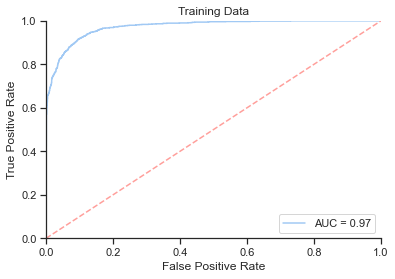

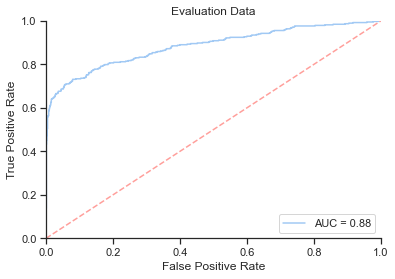

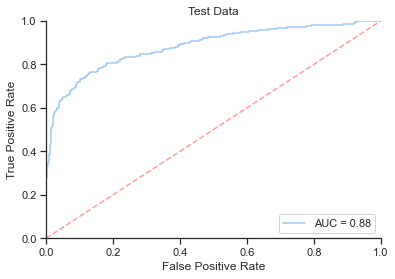

In [16]:
print("Evaluation on Training Data:")
train_runner.evaluate_model()
plt.title("Training Data")

print("Evaluation on Validation Data:")
val_runner.evaluate_model()
plt.title("Evaluation Data")

print("Evaluation on Test Data:")
test_runner.evaluate_model()
plt.title("Test Data")


## Check results from CV experiment to see per peptide performance

For now only has the performance of the CDRs

In [92]:
result = pd.read_csv("../../results/modelling/simplecnn_cdr_scores.csv", index_col=0)

In [95]:
from sklearn import metrics
def calc_auc(x):
    d = {}
    d["auc"] = metrics.roc_auc_score(x["labels"],x["scores"])
    d["counts"] = len(x)
    return pd.Series(d, index=["auc", "counts"])

result = result[result["peptide"].isin(result["peptide"].value_counts(ascending=False).head(10).index)]
auc_df = result.groupby("peptide").apply(calc_auc)

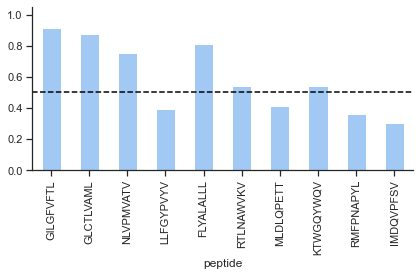

In [109]:
auc_df = auc_df.sort_values("counts",ascending=False)
ax = auc_df.plot.bar(y="auc",ylim=[0,1.05])
ax.axhline(0.5, ls="--", c="black")
plt.tight_layout()
ax.get_legend().remove()
plt.savefig("../../results/modelling/cdr_peptide_auc.png")